In [1]:
import os
import gc
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)

In [52]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    device: str = 'cuda'
    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    imgdir_name: str = "../../data/VinBigData/png256"
    # Model
    model_dir: str = "../ChestXRay14-2Class/results"
    model_mode: str = 'normal'
    model_name: str = 'resnet18'
    
    # Evaluation
    batch_size: int = 32
    num_workers: int = 4

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import torch
assert torch.__version__.startswith("1.7")
from detectron2.structures import BoxMode


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

1.7.1+cu101 True


In [4]:
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F
import timm


class CNNFixedPredictor(nn.Module):
    def __init__(self, cnn: nn.Module, num_classes: int = 2):
        super(CNNFixedPredictor, self).__init__()
        self.cnn = cnn
        self.lin = Linear(cnn.num_features, num_classes)
        print("cnn.num_features", cnn.num_features)

        # We do not learn CNN parameters.
        # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.cnn(x)
        return self.lin(feat)


def build_predictor(model_name: str, model_mode: str = "normal"):
    if model_mode == "normal":
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=True, num_classes=2, in_chans=3)
    elif model_mode == "cnn_fixed":
        # normal configuration. train all parameters.
        # https://rwightman.github.io/pytorch-image-models/feature_extraction/
        timm_model = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        return CNNFixedPredictor(timm_model, num_classes=2)
    else:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_mode}")

        
def accuracy(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape[:-1] == t.shape, f"y {y.shape}, t {t.shape} is inconsistent."
    pred_label = torch.max(y.detach(), dim=-1)[1]
    count = t.nelement()
    correct = (pred_label == t).sum().float()
    acc = correct / count
    return acc


def accuracy_with_logits(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape == t.shape
    gt_label = torch.max(t.detach(), dim=-1)[1]
    return accuracy(y, gt_label)


def cross_entropy_with_logits(input, target, dim=-1):
    loss = torch.sum(- target * F.log_softmax(input, dim), dim)
    return loss.mean()


import torch
import torch.nn.functional as F
from torch import nn
import pytorch_pfn_extras as ppe


class Classifier(nn.Module):
    """two class classfication"""

    def __init__(self, predictor, lossfun=cross_entropy_with_logits):
        super().__init__()
        self.predictor = predictor
        self.lossfun = lossfun
        self.prefix = ""

    def forward(self, image, targets):
        outputs = self.predictor(image)
        loss = self.lossfun(outputs, targets)
        metrics = {
            f"{self.prefix}loss": loss.item(),
            f"{self.prefix}acc": accuracy_with_logits(outputs, targets).item()
        }
        ppe.reporting.report(metrics, self)
        return loss, metrics

    def predict(self, data_loader):
        pred = self.predict_proba(data_loader)
        label = torch.argmax(pred, dim=1)
        return label

    def predict_proba(self, data_loader):
        device: torch.device = next(self.parameters()).device
        y_list = []
        self.eval()
        with torch.no_grad():
            for batch in data_loader:
                if isinstance(batch, (tuple, list)):
                    # Assumes first argument is "image"
                    batch = batch[0].to(device)
                else:
                    batch = batch.to(device)
                y = self.predictor(batch)
                y = torch.softmax(y, dim=-1)
                y_list.append(y)
        pred = torch.cat(y_list)
        return pred

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [18]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


import cv2
import numpy as np


class VinbigdataTwoClassDataset(DatasetMixin):
    def __init__(self, dataset_dicts, image_transform=None, transform=None, train: bool = True,
                 mixup_prob: float = -1.0, label_smoothing: float = 0.0):
        super(VinbigdataTwoClassDataset, self).__init__(transform=transform)
        self.dataset_dicts = dataset_dicts
        self.image_transform = image_transform
        self.train = train
        self.mixup_prob = mixup_prob
        self.label_smoothing = label_smoothing

    def _get_single_example(self, i):
        d = self.dataset_dicts[i]
        filename = d["file_name"]

        img = cv2.imread(filename)
        if self.image_transform:
            img = self.image_transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))

        if self.train:
            label = int(len(d["annotations"]) > 0)  # 0 normal, 1 abnormal
            if self.label_smoothing > 0:
                if label == 0:
                    return img, float(label) + self.label_smoothing
                else:
                    return img, float(label) - self.label_smoothing
            else:
                return img, float(label)
        else:
            # Only return img
            return img, None

    def get_example(self, i):
        img, label = self._get_single_example(i)
        if self.mixup_prob > 0. and np.random.uniform() < self.mixup_prob:
            j = np.random.randint(0, len(self.dataset_dicts))
            p = np.random.uniform()
            img2, label2 = self._get_single_example(j)
            img = img * p + img2 * (1 - p)
            if self.train:
                label = label * p + label2 * (1 - p)

        if self.train:
            label_logit = torch.tensor([1 - label, label], dtype=torch.float32)
            return img, label_logit
        else:
            # Only return img
            return img

    def __len__(self):
        return len(self.dataset_dicts)

In [53]:
config_dict = {}
config = Config().update(config_dict)
base_dir = Path().resolve()

In [54]:
config

Config(device='cuda', imgconf_file='../../data/VinBigData/train.csv', imgdir_name='../../data/VinBigData/png256', model_dir='../ChestXRay14-2Class/results', model_mode='normal', model_name='resnet18', batch_size=32, num_workers=4)

In [57]:
device = torch.device(config.device)
predictor = build_predictor(model_name=config.model_name, model_mode=config.model_mode)
predictor.load_state_dict(torch.load(base_dir / config.model_dir / 'predictor_last.pt'))
predictor.eval()

classifier = Classifier(predictor)
classifier.to(device)
print()

In [40]:
train = pd.read_csv(base_dir / config.imgconf_file)

dataset_dicts = get_vinbigdata_dicts(base_dir / config.imgdir_name, train, debug=False)
dataset = VinbigdataTwoClassDataset(dataset_dicts)

Creating data...
image shape: (256, 256, 3)


  0%|          | 0/15000 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_original_debug0.pkl


In [68]:
from torch.utils.data.dataloader import DataLoader


valid_dataset = VinbigdataTwoClassDataset(dataset_dicts)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=True,
)

valid_pred = classifier.predict_proba(valid_loader).cpu().numpy()
valid_pred_df = pd.DataFrame({
    "image_id": [dd["image_id"] for dd in dataset_dicts],
    "class0": valid_pred[:, 0],
    "class1": valid_pred[:, 1],
    "truth": [int(len(d["annotations"]) > 0) for d in dataset_dicts],
})

In [69]:
valid_pred_df

,image_id,class0,class1,truth
0,4d390e07733ba06e5ff07412f09c0a92,0.863667,1.363332e-01,0
1,289f69f6462af4933308c275d07060f0,0.999127,8.730373e-04,0
2,68335ee73e67706aa59b8b55b54b11a4,0.760983,2.390170e-01,0
3,7ecd6f67f649f26c05805c8359f9e528,0.996463,3.536960e-03,1
4,2229148faa205e881cf0d932755c9e40,0.999969,3.084141e-05,1
...,...,...,...,...
14995,b3510302f95f75a91e0fd49e04767f02,0.999721,2.785048e-04,1
14996,dcb081bb5e1dac41000e96fc37c8c322,0.999945,5.494593e-05,1
14997,c619a784636c085eb798f98a5ba1102d,1.000000,3.472597e-09,1
14998,e7ea94b2fec95a7461b10a7f3eea2897,0.740925,2.590748e-01,1


/home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


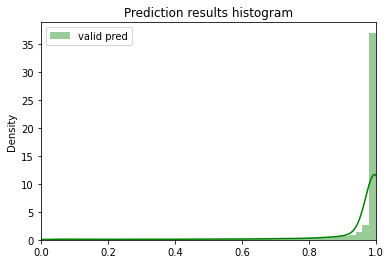

In [70]:
sns.distplot(valid_pred_df["class0"].values, color='green', label='valid pred')
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()

In [79]:
from sklearn.metrics import accuracy_score


accuracy_score(valid_pred_df['class1'].values > 0.5, valid_pred_df['truth'].values)

0.6986666666666667

In [ ]:
# --- Prediction ---
# valid data


# test data
test_meta = pd.read_csv(inputdir / "vinbigdata-testmeta" / "test_meta.csv")
dataset_dicts_test = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
test_dataset = VinbigdataTwoClassDataset(dataset_dicts_test, train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)
test_pred = classifier.predict_proba(test_loader).cpu().numpy()
test_pred_df = pd.DataFrame({
    "image_id": [d["image_id"] for d in dataset_dicts_test],
    "class0": test_pred[:, 0],
    "class1": test_pred[:, 1]
})
test_pred_df.to_csv(outdir/"test_pred.csv", index=False)